In [1]:
import pandas as pd
import unidecode as uni
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

def generar_vecinos(p_data):
    data = p_data
    
    df2 = pd.get_dummies(data.Name)
    df3 = data[['fecha_anio','budget','apropiado']]
    
    df = pd.concat([df2,df3],axis=1)
    df = df.dropna()
    X = np.array(df)
    KMeans_ = KMeans(n_clusters=200, n_init=2,init='random',random_state=0).fit(X)

    
    return pd.Series(KMeans_.labels_)


## UNIR DATASETS DE ACTORES CON PELICULAS

In [2]:
creador = pd.read_csv('Creator.csv')
person = pd.read_csv('Person.csv')
creador_person = creador.merge(person,how='inner',left_on='IDPerson', right_on='ID')
nom_individual = pd.read_csv('AwardNominationIndividual.csv')
creador_person['IDPerson'] = creador_person.IDPerson[creador_person.IDPerson.notnull()].astype(int)
creador_person_nom_indv = creador_person.merge(nom_individual,how='inner',left_on='IDPerson',right_on='IDPerson')
creador_person_nom_indv = creador_person_nom_indv[['IDMovie','Importance','IDPerson','Role','FullName','Winner','Category']]
nom_creador = pd.read_csv('AwardNominationCreator.csv')
creador_person_nom = creador_person_nom_indv.merge(nom_creador,how='left',left_on='IDPerson',right_on='IDCreator')
creador_person_nom_creador = pd.concat([creador_person_nom.iloc[:,:7],creador_person_nom[['Winner_y','Category_y','IDCreator']]],axis=1)
movieGenre = pd.read_csv('MovieGenre.csv')
movie = pd.read_csv('Movie.csv')
movie_genre = movie.merge(movieGenre,how='inner',left_on='ID',right_on='IDMovie')
genre = pd.read_csv('Genre.csv')
movie_genre = movie_genre.merge(genre,how='inner',left_on='IDGenre',right_on='id')
movie_genre = movie_genre[['ID','RuntimeMinutes','Title','Name']]
movie_actor = movie_genre.merge(creador_person_nom,how='inner',left_on='ID',right_on='IDMovie')
movies_metadata = pd.read_csv('movies_metadata.csv')
movie_actor['Title'] = movie_actor.Title.astype(str).apply(uni.unidecode).str.lower()
movies_metadata['original_title'] = movies_metadata.original_title.astype(str).apply(uni.unidecode).str.lower()
movies_metadata = movies_metadata[['adult','budget','release_date','revenue','popularity','original_title']]
movie_actor_metadata = movie_actor.merge(movies_metadata,how='inner',left_on='Title',right_on='original_title')
df_actores = movie_actor_metadata[movie_actor_metadata.Role.str.contains('actor')]
df_tecnicos = movie_actor_metadata[~(movie_actor_metadata.Role.str.contains('actor'))]
df_actores = df_actores[df_actores.Category_x.str.contains('act')]
df_actores['Winner_y'] = df_actores.Winner_y.fillna('Sin Nominacion')
df_actores['Winner_x'] = df_actores.Winner_x.fillna('Sin Nominacion')
df_tecnicos['Winner_y'] = df_tecnicos.Winner_y.fillna('Sin Nominacion')
df_tecnicos['Winner_x'] = df_tecnicos.Winner_x.fillna('Sin Nominacion')
df_actores_premios = df_actores[['Title','FullName','Winner_x']]
df_actores_premios['Winner_x'] = df_actores_premios.Winner_x.apply(lambda x: 1 if x else 0)
data_apropiado = pd.read_csv('data_apropiado.csv',sep='|').iloc[:,1:]
data_apropiado = data_apropiado.drop_duplicates()
df_actores = df_actores.merge(data_apropiado,how='left',left_on='Title',right_on='Title')
df_actores['Winner_x'] = df_actores.Winner_x.apply(lambda x: 1 if x else 0)
premios_por_actor = pd.DataFrame(df_actores.groupby(['FullName'])['Winner_x'].sum()).reset_index()
premios_por_actor = premios_por_actor.drop_duplicates()
df_actores = df_actores.merge(premios_por_actor,how='left',left_on='FullName',right_on='FullName')
df_actores['Winner_x_y'] = pd.qcut(df_actores.Winner_x_y,2,labels=[0,1])
df_actores['fecha_anio'] = df_actores.release_date[df_actores.release_date.notnull()].str.split(pat='-').apply(lambda x: x[0])
df_actores = df_actores[['Title','budget','FullName','apropiado','Name','fecha_anio','RuntimeMinutes','Winner_x_y']]
df_actores = df_actores.dropna()
df_actores = df_actores.drop_duplicates()
df_actores = df_actores.reset_index().iloc[:,1:]
df_actores['cluster_kmeans'] = pd.Series(generar_vecinos(df_actores))
df_actores = df_actores[df_actores.budget.astype(int)>0]
df_actores_cluster = df_actores[['Title','cluster_kmeans']].drop_duplicates()
#df_actores_cluster.to_csv('cluster_kmeans_df.csv',sep='|')
#df_actores_cluster = pd.read_csv('cluster_kmeans_df.csv',sep='|')


diccionario_actores = {}#diccionario_actores
for i in range(0,200):
    lista_actores_cluster = df_actores.FullName[df_actores.cluster_kmeans==i].unique()
    add_diccionario = {i:lista_actores_cluster}
    diccionario_actores.update(add_diccionario)
#import pickle
#with open('dict_actores_kmeans.pickle', 'wb') as handle:
#    pickle.dump(diccionario_actores, handle, protocol=pickle.HIGHEST_PROTOCOL)

df_actores_cluster = df_actores[['Title','cluster_kmeans']]

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_la

## IMPORTAR DATASET

In [3]:
df_actores_cluster = pd.read_csv('df_actores_cluster.csv',sep='|').iloc[:,1:]

## PREDECIR ACTORES OPTIMOS

In [4]:
import pandas as pd
import numpy as np
import pandas_profiling 
import seaborn as sns
import matplotlib.pyplot as plt
from string import ascii_letters
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix,accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
import unidecode as uni
import time
import pickle
pd.set_option('display.max_columns', None)
#with open('dict_actores.pickle', 'rb') as handle:
#    dict_actores = pickle.load(handle)
with open('dict_actores_kmeans.pickle', 'rb') as handle:
    dict_actores_kmeans = pickle.load(handle)
    

In [5]:
data = pd.read_csv('data_movies_final.csv',sep='|').iloc[:,1:]
data['Rate'][data.Rate>10] = data.Rate[data.Rate>10]*0.10
data['fecha_mes'] = data['fecha'][data.fecha.notnull()]
dummies_meses = pd.get_dummies(data.fecha_mes[data.fecha_mes.notnull()].str.split(pat='-').apply(lambda x: x[1])).rename(columns={'01':'ENERO','02':'FEBRERO','03':'MARZO','04':'ABRIL','05':'MAYO','06':'JUNIO','07':'JULIO','08':'AGOSTO','09':'SEPTIEMBRE','10':'OCTUBRE','11':'NOVIEMBRE','12':'DICIEMBRE'})
data = pd.concat([data,dummies_meses],axis=1)
data = data[data.fecha_mes.notnull()]
data = data.drop(['IDDataLens','cant_baja_votos','cant_media_votos','cant_alta_votos','fecha_mes'],axis=1)
data = data.drop(['fecha','largo_letras_titulo','popularity'],axis=1)
df_rate = pd.DataFrame(data.groupby(['Title'])['Rate'].mean()).reset_index()
data = data.merge(df_rate,how='left',left_on='Title',right_on='Title')
data = data.drop(['Rate_x'],axis=1)
data = data.iloc[:,:24]
df_actores_cluster = df_actores_cluster.drop_duplicates()
data = data.merge(df_actores_cluster,how='left',left_on='Title',right_on='Title')
data = data[data.cluster_kmeans.notnull()]
data_apropiado = pd.read_csv('data_apropiado.csv',sep='|').iloc[:,1:]
data_apropiado = data_apropiado.drop_duplicates()
data = data.merge(data_apropiado,how='left',left_on='Title',right_on='Title')
data = data.drop(['Title'],axis=1)
df = data.dropna()
df = data.drop_duplicates()
df = df.dropna()
df = df.drop_duplicates()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


## SEPARO X y

In [6]:
X = df.drop(['cluster_kmeans'],axis=1)
y = df.cluster_kmeans

In [7]:
from xgboost.sklearn import XGBClassifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
XGBClassifier = XGBClassifier(max_depth=35,iterations=35,alpha=0,learning_rate=0.3)
modelo = XGBClassifier.fit(X_train,y_train)
predict = modelo.predict(X_test)

/opt/conda/lib/python3.6/site-packages/dask/dataframe/utils.py:13: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [8]:
print('accuracy: '+str(accuracy_score(y_test, predict, normalize=True)))
print('precision: '+str(precision_score(y_test,predict,average='macro')))
print('recall: '+str(recall_score(y_test,predict,average='macro')))        
print(classification_report(y_test,predict))
print('')
print(confusion_matrix(y_test,predict))

accuracy: 0.6122231686541738
precision: 0.3564547335424973
recall: 0.3611988471732863
              precision    recall  f1-score   support

         0.0       0.71      0.75      0.73       165
         2.0       0.00      0.00      0.00         3
         5.0       0.50      0.60      0.54       169
         6.0       0.00      0.00      0.00        15
         7.0       0.67      0.67      0.67        54
        10.0       0.71      0.60      0.65        73
        15.0       0.00      0.00      0.00         1
        16.0       0.57      0.54      0.55        24
        17.0       0.00      0.00      0.00         2
        18.0       0.41      0.62      0.49        21
        19.0       0.43      0.38      0.40        24
        20.0       0.59      0.58      0.58       144
        22.0       0.00      0.00      0.00         1
        23.0       0.00      0.00      0.00         1
        24.0       0.00      0.00      0.00         1
        25.0       0.68      0.80      0.73      

/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1221: 

Text(335.5, 0.5, 'Etiquetas verdaderas')

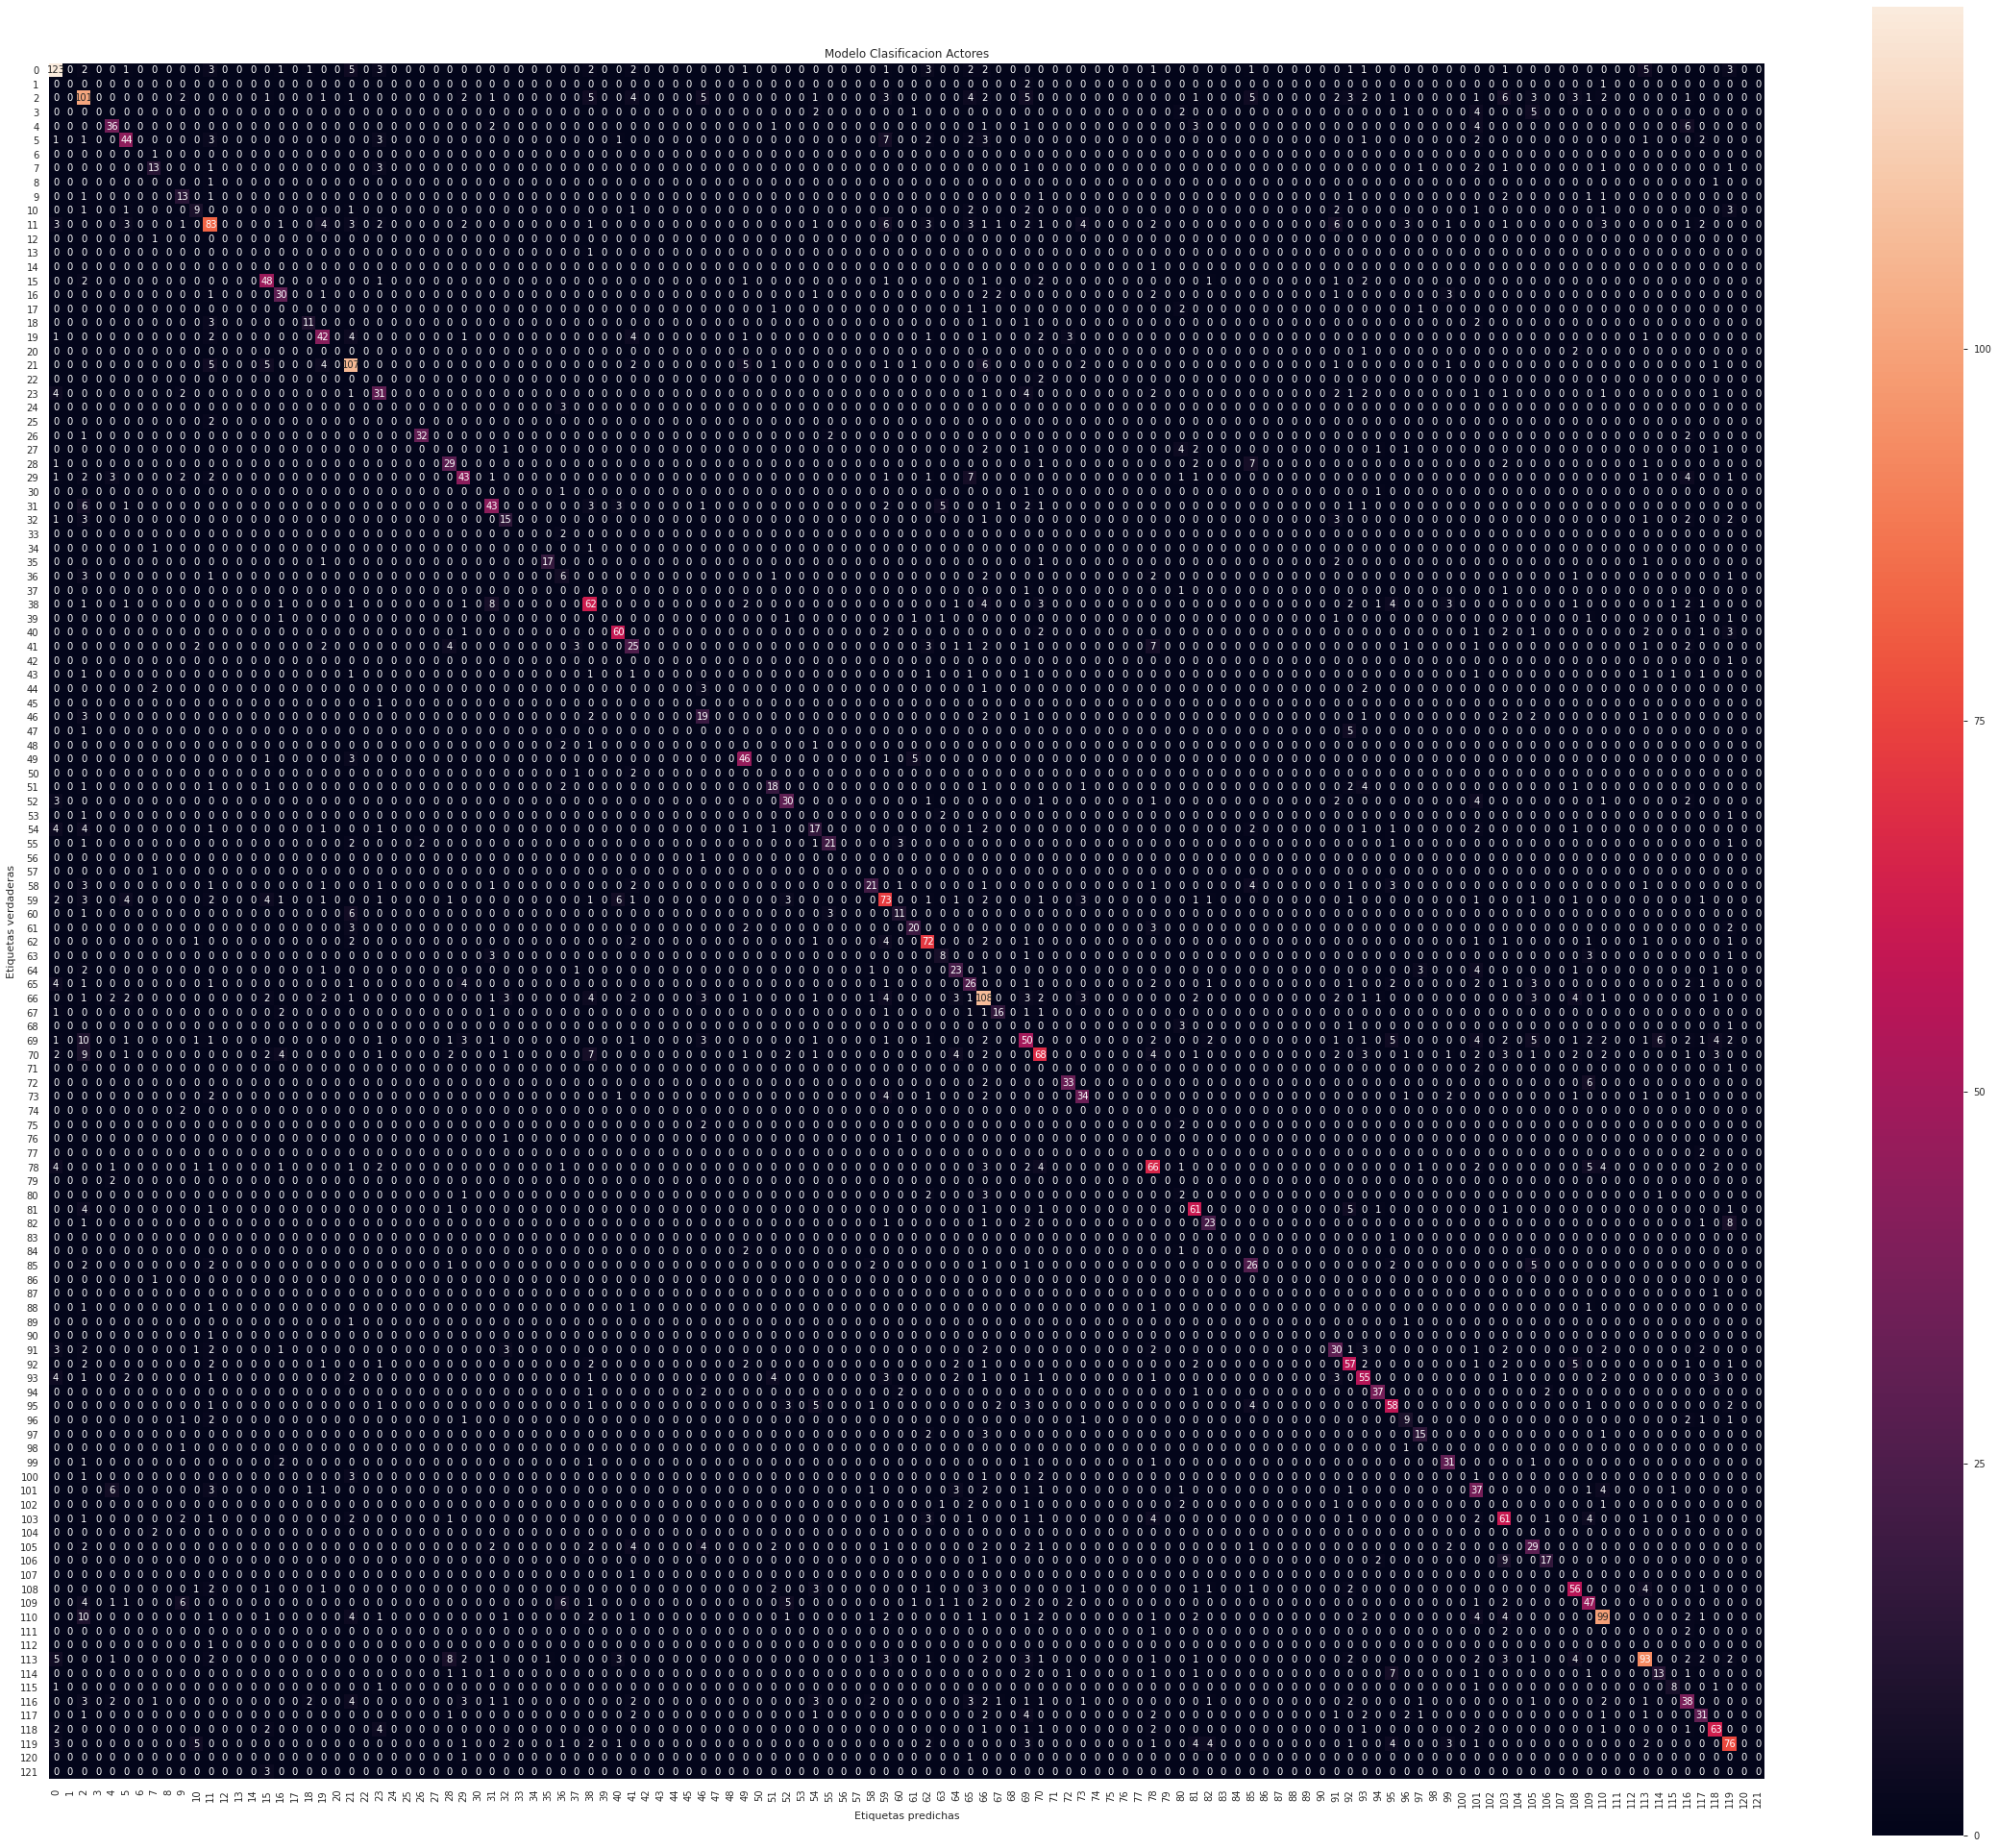

In [9]:
mat = confusion_matrix(y_test,predict)
plt.figure(figsize=(40,35))
sns.heatmap(mat, square=True, annot=True, fmt='d')
plt.title('Modelo Clasificacion Actores')
plt.xlabel('Etiquetas predichas')
plt.ylabel('Etiquetas verdaderas')

## ANALISIS DE RESULTADOS

In [12]:
import lime
import lime.lime_tabular
df_new = X_test
df_array = df_new.sample(1)
import shap  
shap.initjs()

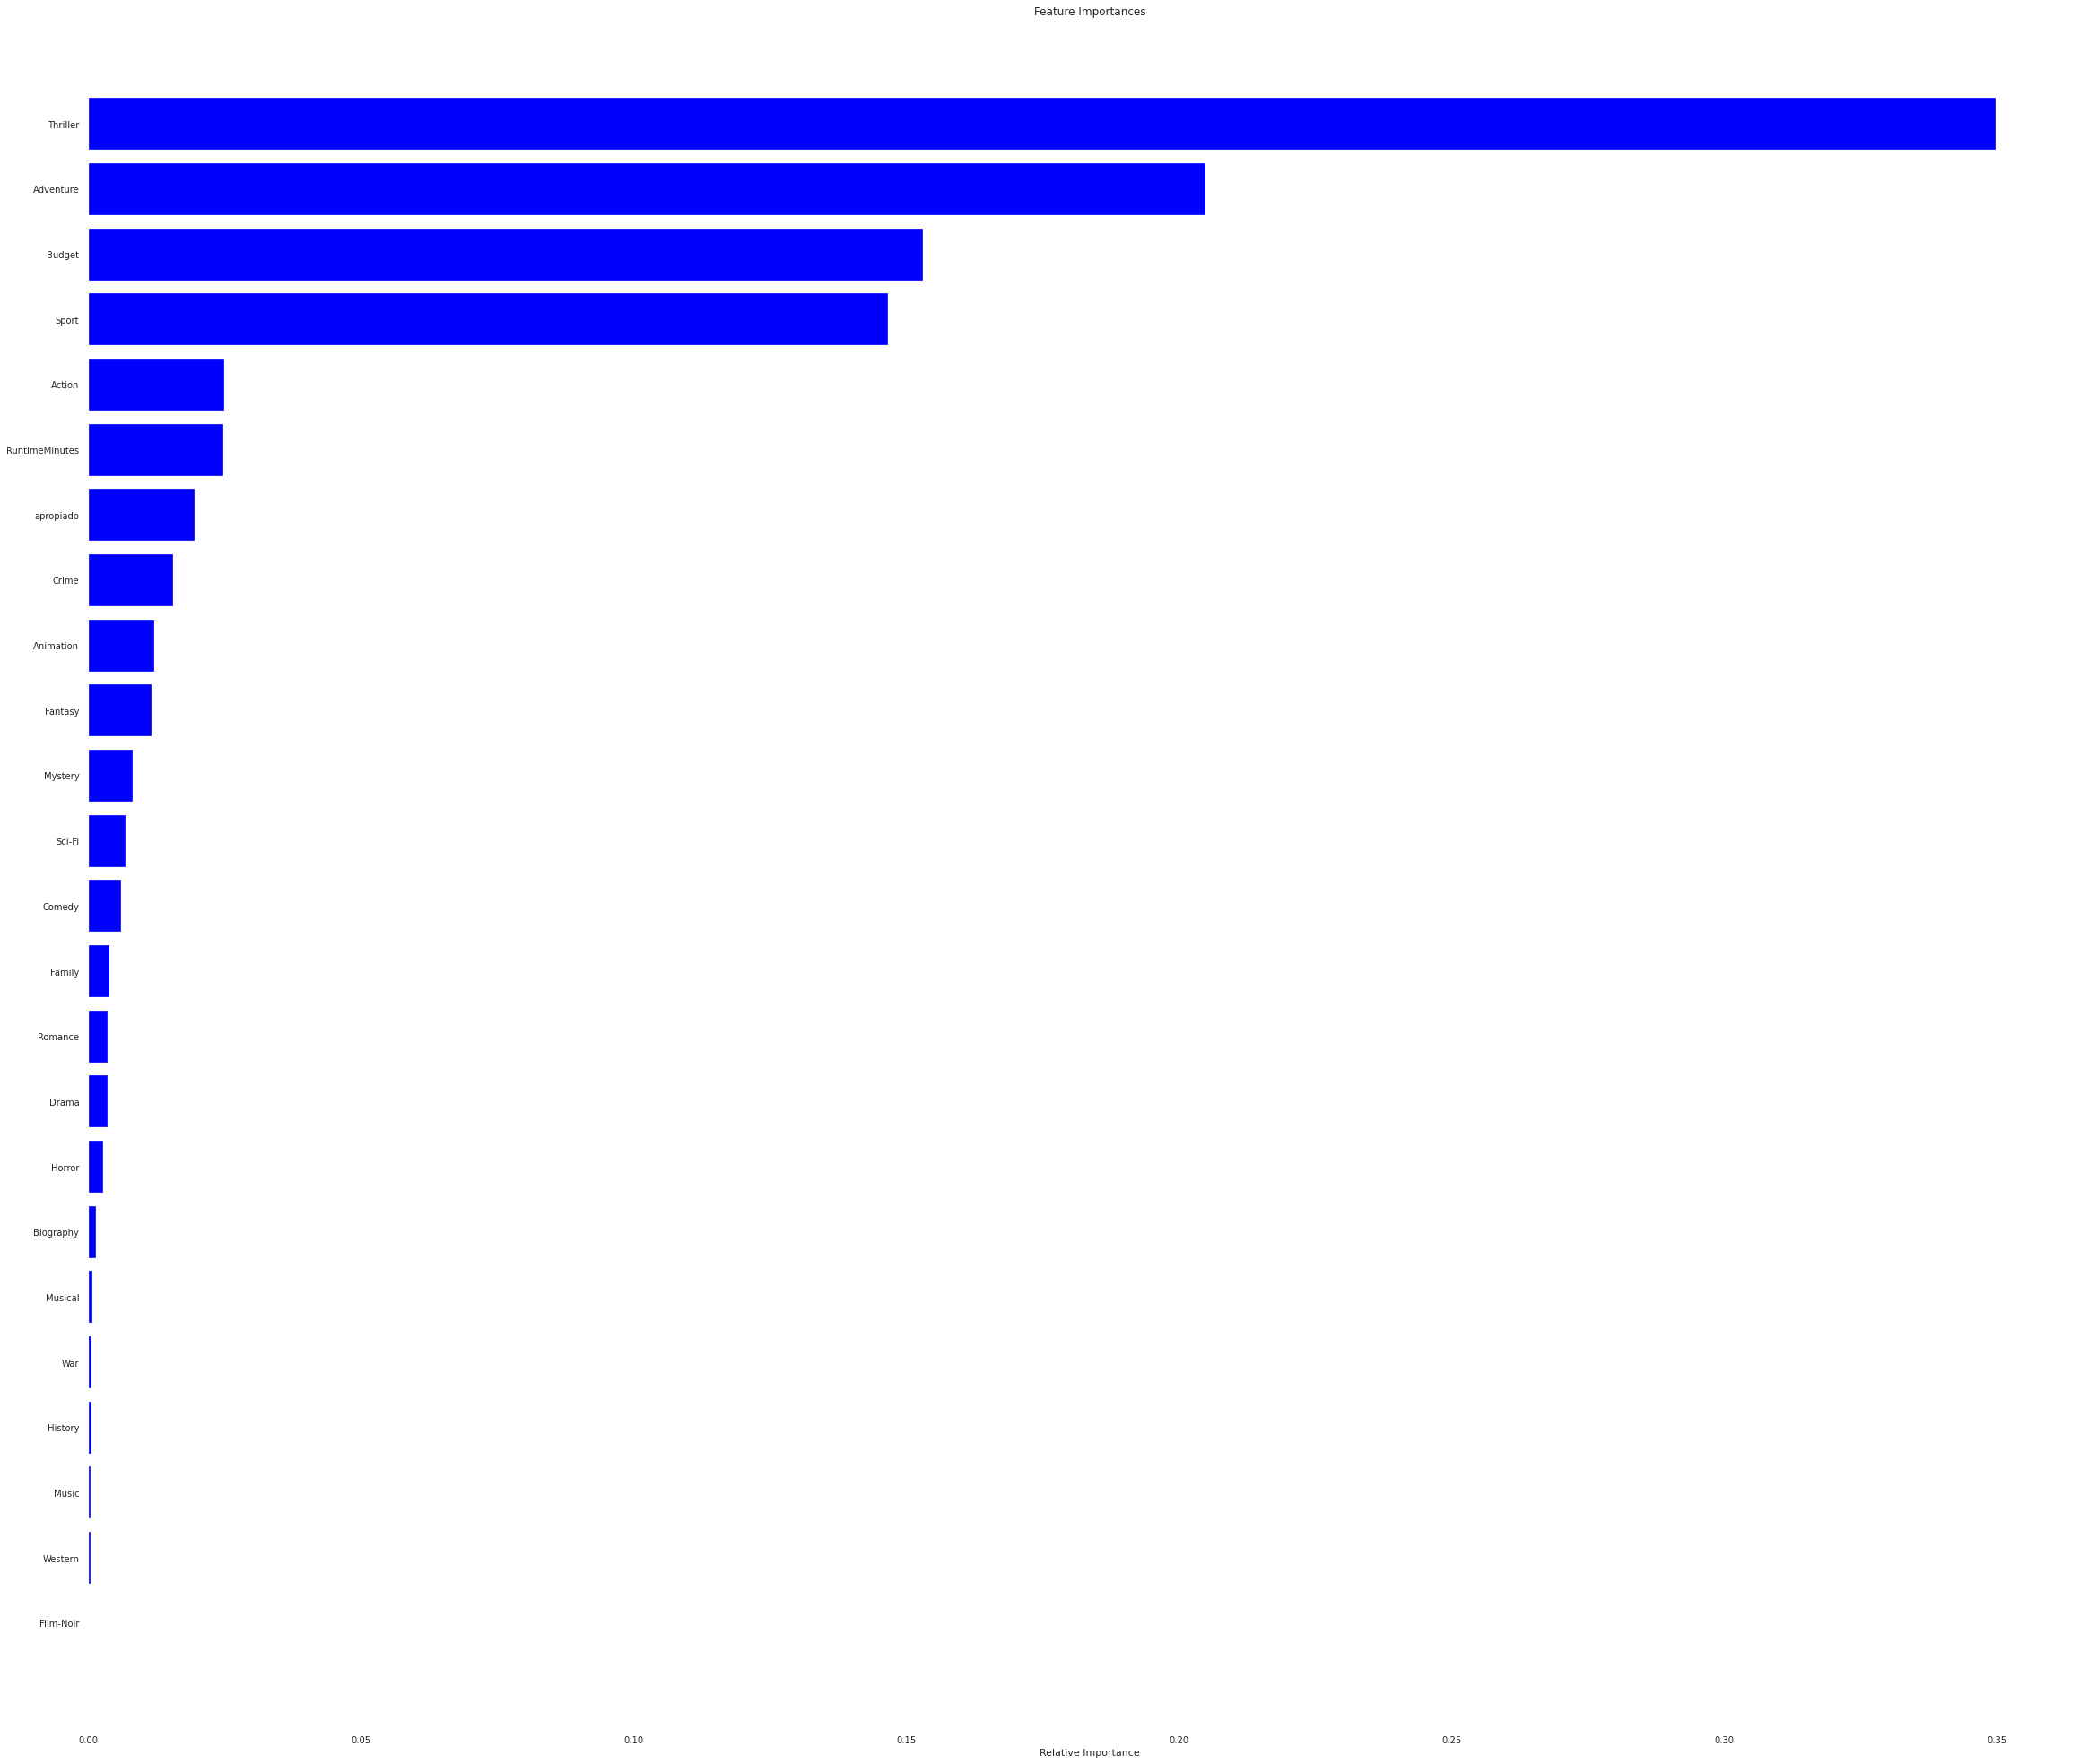

In [13]:
plt.figure(figsize=(40,35))
importances = modelo.feature_importances_
indices = np.argsort(importances)
features = X_train.columns
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

## EXPLAINER

In [31]:
explainer = shap.TreeExplainer(XGBClassifier)
shap_values = explainer.shap_values(df_array)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [32]:
modelo.predict(df_array)[0]

74.0

In [33]:
features = df_array.columns
index = int(modelo.predict(df_array)[0])
shap.force_plot(explainer.expected_value[index], shap_values[index], df_array,feature_names=features,out_names=['actores predichos'])

In [34]:
explainer = shap.TreeExplainer(modelo)
shap_values = explainer.shap_values(X_test.sample(500))

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


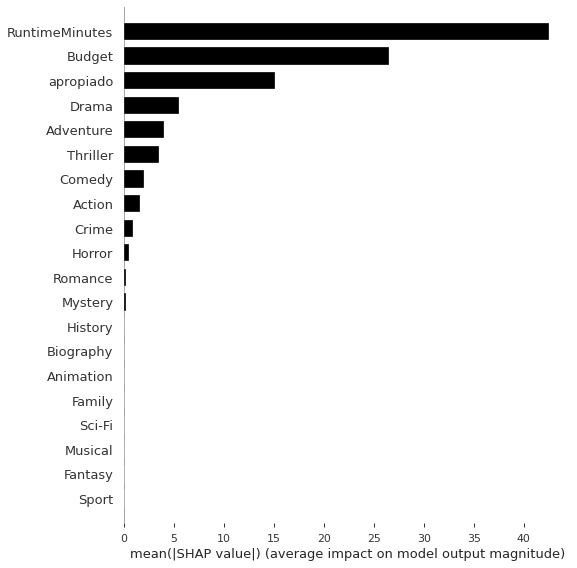

In [35]:
shap.summary_plot(shap_values[index], X_test.sample(500), plot_type="bar",color='black')

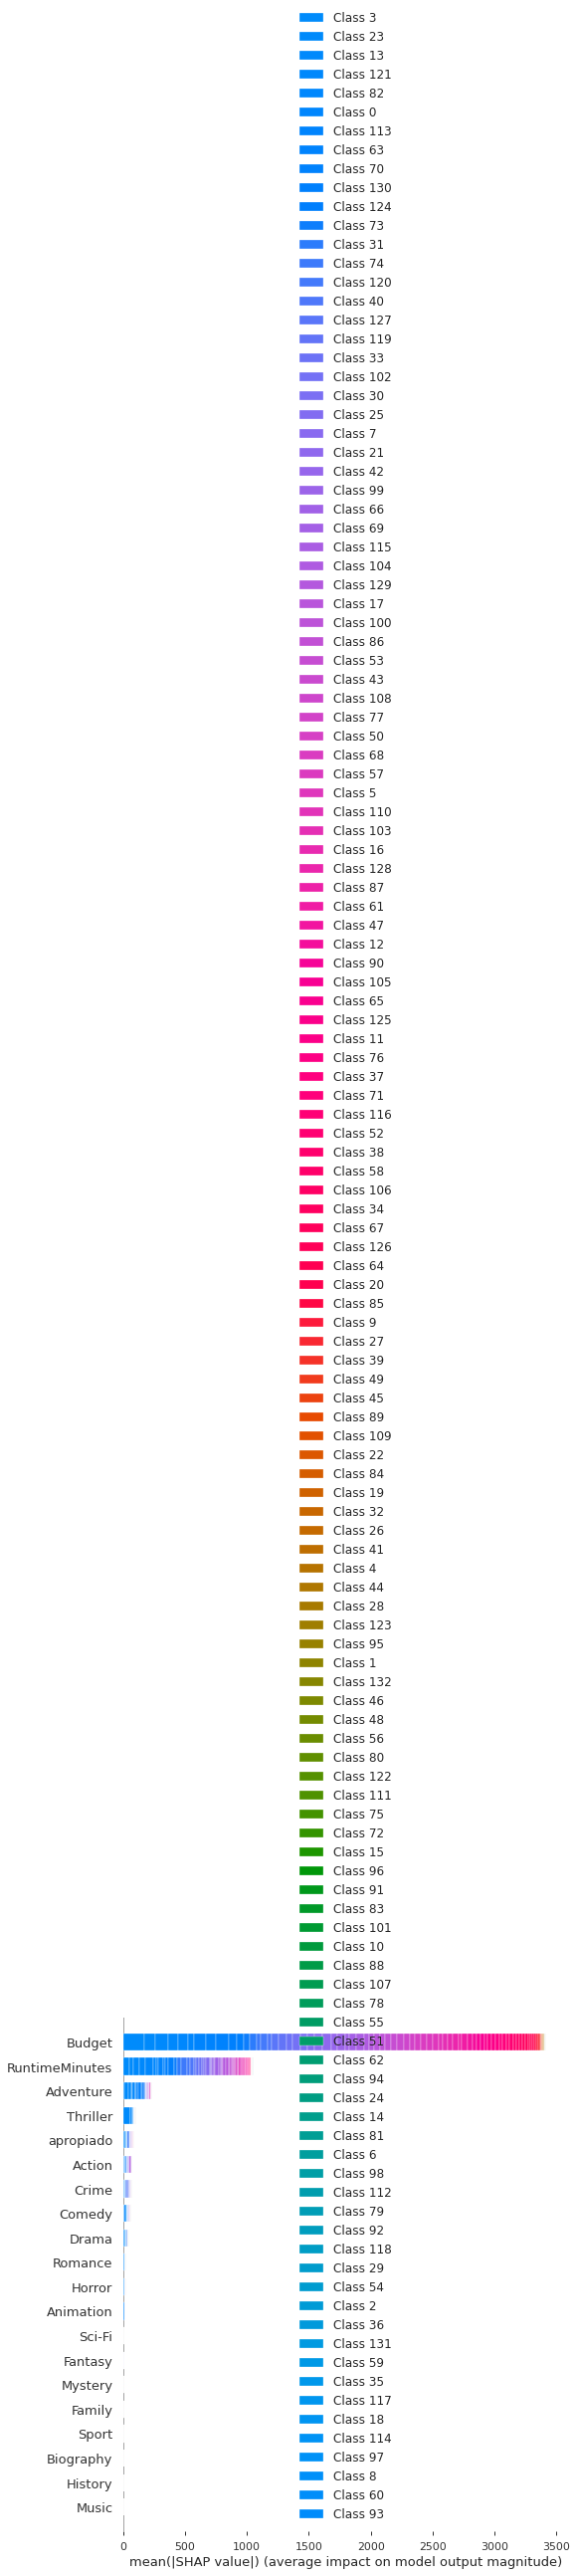

In [36]:
shap.summary_plot(shap_values, X_test.sample(1000))

## RECOMENDACIONES DE ACTORES

In [77]:
predecir_actores = X_test[X_test.Budget>10000000].sample(1)

In [78]:
predecir_actores

,Budget,RuntimeMinutes,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Film-Noir,History,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Sport,Thriller,War,Western,apropiado
81620,70000000.0,133,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [79]:
dict_actores_kmeans[modelo.predict(predecir_actores)[0]]

array(['Jim Davis', 'David Huddleston', 'Anthony Hopkins', 'Chris Rock',
       'Peter Stormare', 'Maud Forget', 'Frank Langella', 'Ellen Barkin',
       'Michael Beach', 'Laurence Fishburne', 'Jeff Goldblum',
       'Pete Postlethwaite', 'Julianne Moore', 'Vince Vaughn',
       'Ian McKellen', 'Claire Danes', 'Sienna Miller', 'Charlie Cox',
       'Larry Hagman', 'Kristen Stewart', 'Robert Pattinson',
       'Taylor Lautner', 'Harrison Ford', 'Anne Heche',
       'Jacqueline Obradors', 'David Schwimmer', 'Asia Argento',
       'Samuel L. Jackson', 'Marton Csokas', 'Vin Diesel',
       'Albert Finney', 'Jessica Lange', 'Ewan McGregor', 'Billy Crudup',
       'Mako', 'David Thewlis', 'Brad Pitt', 'BD Wong',
       'Michelle Pfeiffer', 'Val Kilmer', 'Sandra Bullock',
       'Ralph Fiennes', 'Dustin Hoffman', 'Bob Hoskins', 'Robin Williams',
       'Julia Roberts', 'Sylvester Stallone', 'John Lithgow',
       'Michael Rooker', 'Janine Turner', 'Gérard Depardieu',
       'Michelle Yeoh', '